# Предварительная настройка

## Начальные условия

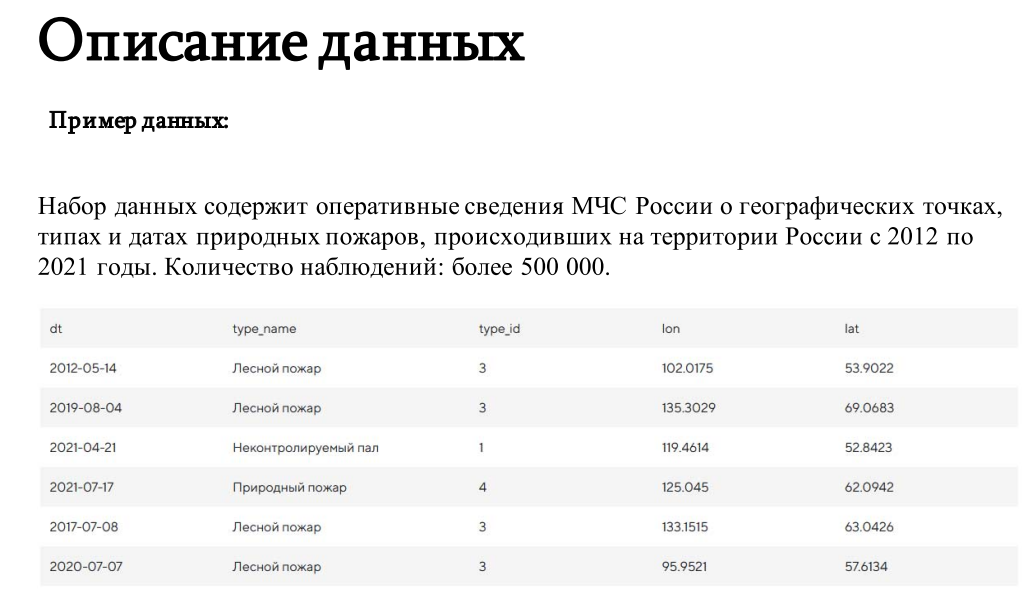
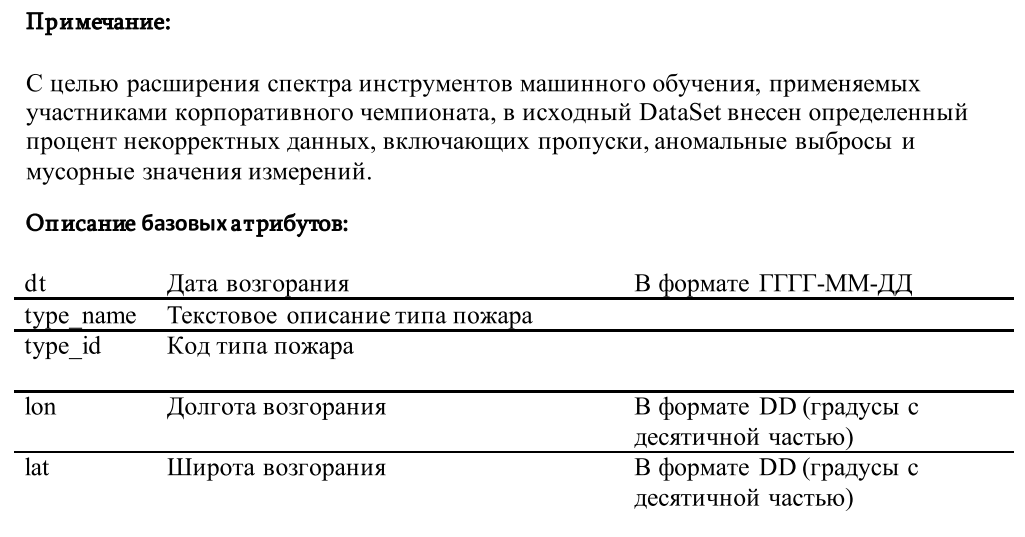
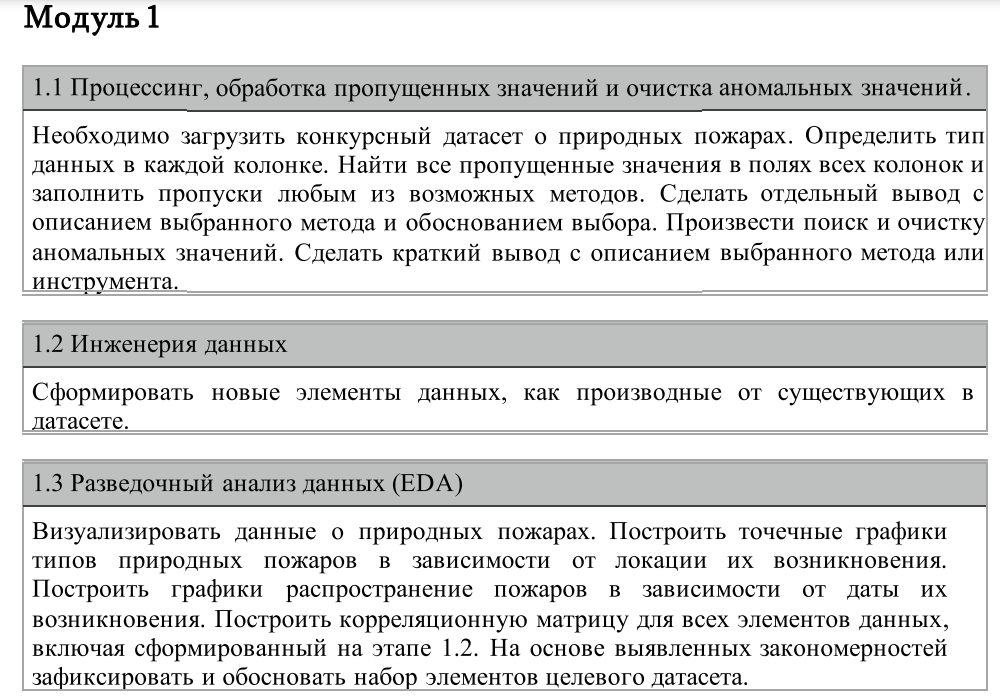
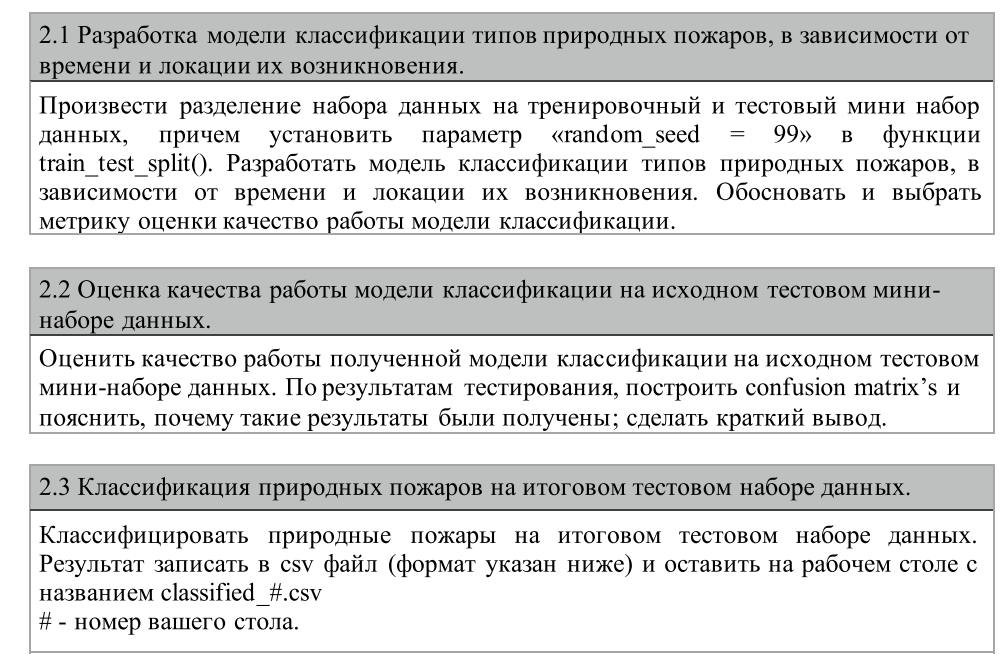
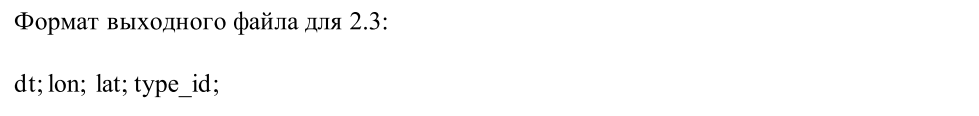
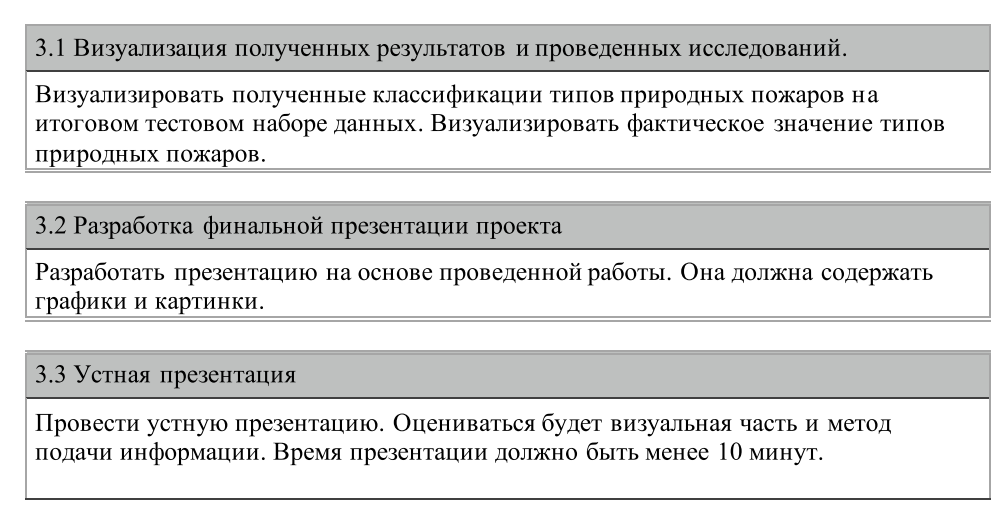

## Импорты библиотек

In [133]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import hyperopt
from sklearn.model_selection import StratifiedKFold
from functools import partial
from sklearn import metrics
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll.base import scope
import lightgbm as lgb
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [64]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Используемые файлы

In [65]:
codebook_file_path = r'C:\Users\Lenovo\Desktop\rt\КЧ2022\codebook.csv'
meta_file_path = r'C:\Users\Lenovo\Desktop\rt\КЧ2022\meta.csv'
sample_file_path = r'C:\Users\Lenovo\Desktop\rt\КЧ2022\sample_202.csv'
thermopoints_file_path = r'C:\Users\Lenovo\Desktop\rt\КЧ2022\thermopoints.csv'

# Предобработка

## Скачивание данных

In [66]:
data = pd.read_csv(thermopoints_file_path, sep=';')

In [67]:
# создадим искусственные пропуски
data.loc[0:4, 'lon'] = np.nan

In [68]:
data

,dt,type_name,type_id,lon,lat
0,2012-03-13,Природный пожар,4,NaN,47.8662
1,2012-03-13,Природный пожар,4,NaN,47.8809
2,2012-03-13,Лесной пожар,3,NaN,48.4973
3,2012-03-13,Природный пожар,4,NaN,43.6277
4,2012-03-13,Природный пожар,4,NaN,47.8581
...,...,...,...,...,...
660249,2021-09-10,Лесной пожар,3,118.5451,64.7475
660250,2021-09-10,Лесной пожар,3,118.3046,64.7629
660251,2021-09-10,Лесной пожар,3,117.9681,65.7394
660252,2021-09-10,Лесной пожар,3,119.0462,64.7541


In [69]:
# кол-во пропусков
data.isna().sum()

dt           0
type_name    0
type_id      0
lon          5
lat          0
dtype: int64

In [70]:
# кол-во дубликатов
data.duplicated().sum()

1466

In [71]:
data = data.drop_duplicates()
data.duplicated().sum()

0

## Определение типов данных

In [72]:
data.dtypes

dt            object
type_name     object
type_id        int64
lon          float64
lat          float64
dtype: object

In [73]:
# переведём dt в формат datetime
data['dt'] = data['dt'].astype('datetime64')

In [74]:
data.dtypes

dt           datetime64[ns]
type_name            object
type_id               int64
lon                 float64
lat                 float64
dtype: object

## Заполнение пропусков

In [75]:
imputer = KNNImputer(n_neighbors=2)
filled_data = imputer.fit_transform(data.loc[:, ['lon', 'lat']])
data.loc[:, ['lon', 'lat']] = filled_data
data.isna().sum()

dt           0
type_name    0
type_id      0
lon          0
lat          0
dtype: int64

In [76]:
data

,dt,type_name,type_id,lon,lat
0,2012-03-13,Природный пожар,4,132.44665,47.8662
1,2012-03-13,Природный пожар,4,131.70340,47.8809
2,2012-03-13,Лесной пожар,3,133.76265,48.4973
3,2012-03-13,Природный пожар,4,90.99645,43.6277
4,2012-03-13,Природный пожар,4,131.99270,47.8581
...,...,...,...,...,...
660249,2021-09-10,Лесной пожар,3,118.54510,64.7475
660250,2021-09-10,Лесной пожар,3,118.30460,64.7629
660251,2021-09-10,Лесной пожар,3,117.96810,65.7394
660252,2021-09-10,Лесной пожар,3,119.04620,64.7541


## Отсеивание аномальных значений

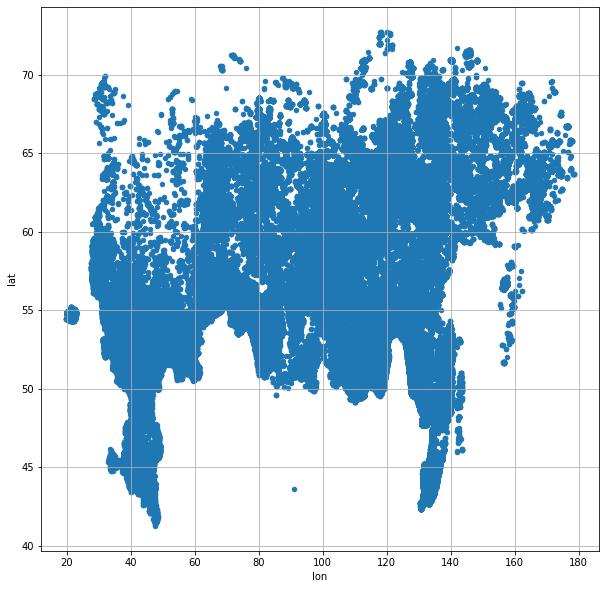

In [77]:
data.plot(x = 'lon', y = 'lat', kind='scatter', figsize = (10, 10), grid=True);

In [78]:
coordinates_array = data[['lon', 'lat']].to_numpy()

In [79]:
coordinates_array

array([[132.44665,  47.8662 ],
       [131.7034 ,  47.8809 ],
       [133.76265,  48.4973 ],
       ...,
       [117.9681 ,  65.7394 ],
       [119.0462 ,  64.7541 ],
       [114.6958 ,  64.5745 ]])

In [80]:
# 0.003 - ожидаемый процент выбросов
isolation_model = IsolationForest(contamination = 0.003)
 
isolation_model.fit(coordinates_array)

IF_predictions = list(isolation_model.predict(coordinates_array))

data['geography_group'] = IF_predictions

In [81]:
data['geography_group'].value_counts()

 1    656847
-1      1941
Name: geography_group, dtype: int64

In [82]:
outliners_data = data.query('geography_group == -1')
noramal_data = data.query('geography_group != -1')

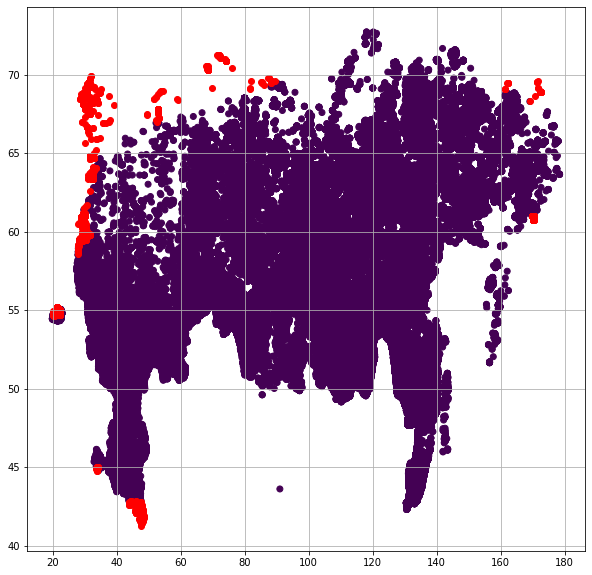

In [83]:
colors = noramal_data['geography_group']
plt.figure(figsize=(10,10))
plt.scatter(x = noramal_data['lon'], y = noramal_data['lat'], c = colors)
plt.scatter(x = outliners_data['lon'], y = outliners_data['lat'], c = 'r')
plt.grid(visible=True);

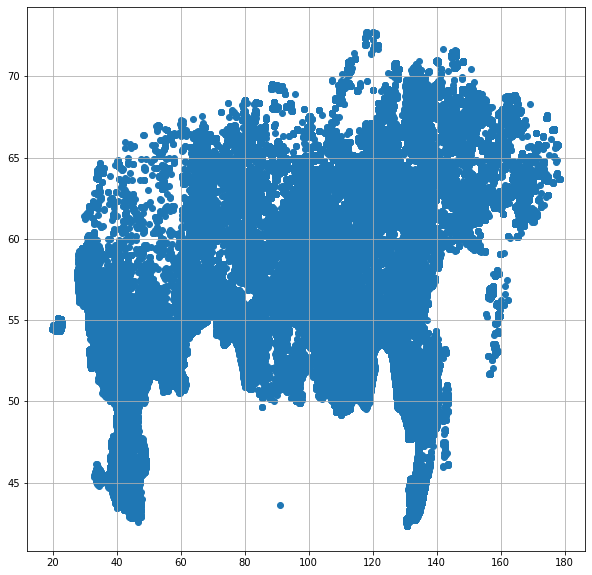

In [84]:
# отбрасываем классы с аномальными признаками
data = data.query('geography_group != -1').reset_index(drop=True)
plt.figure(figsize=(10,10))
plt.scatter(x = data['lon'], y = data['lat'])
plt.grid(visible=True);

In [85]:
del data['geography_group']

## Генерация новых признаков

In [86]:
data['year'] = data.dt.dt.year
data['month'] = data.dt.dt.month
data['week'] = data.dt.dt.week

In [87]:
data

,dt,type_name,type_id,lon,lat,year,month,week
0,2012-03-13,Природный пожар,4,132.44665,47.8662,2012,3,11
1,2012-03-13,Природный пожар,4,131.70340,47.8809,2012,3,11
2,2012-03-13,Лесной пожар,3,133.76265,48.4973,2012,3,11
3,2012-03-13,Природный пожар,4,90.99645,43.6277,2012,3,11
4,2012-03-13,Природный пожар,4,131.99270,47.8581,2012,3,11
...,...,...,...,...,...,...,...,...
656842,2021-09-10,Лесной пожар,3,118.54510,64.7475,2021,9,36
656843,2021-09-10,Лесной пожар,3,118.30460,64.7629,2021,9,36
656844,2021-09-10,Лесной пожар,3,117.96810,65.7394,2021,9,36
656845,2021-09-10,Лесной пожар,3,119.04620,64.7541,2021,9,36


In [88]:
# удалим type_name
types_dict = data.groupby('type_id')['type_name'].first().to_dict()
types_dict

{1: 'Неконтролируемый пал',
 2: 'Торфяной пожар',
 3: 'Лесной пожар',
 4: 'Природный пожар',
 5: 'Контролируемый пал'}

In [89]:
data['type_name'].value_counts()

Лесной пожар            304891
Неконтролируемый пал    153697
Контролируемый пал      101523
Природный пожар          96277
Торфяной пожар             459
Name: type_name, dtype: int64

In [90]:
data['type_id'].value_counts()

3    304891
1    153697
5    101523
4     96277
2       459
Name: type_id, dtype: int64

In [91]:
del data['type_name']

In [92]:
data

,dt,type_id,lon,lat,year,month,week
0,2012-03-13,4,132.44665,47.8662,2012,3,11
1,2012-03-13,4,131.70340,47.8809,2012,3,11
2,2012-03-13,3,133.76265,48.4973,2012,3,11
3,2012-03-13,4,90.99645,43.6277,2012,3,11
4,2012-03-13,4,131.99270,47.8581,2012,3,11
...,...,...,...,...,...,...,...
656842,2021-09-10,3,118.54510,64.7475,2021,9,36
656843,2021-09-10,3,118.30460,64.7629,2021,9,36
656844,2021-09-10,3,117.96810,65.7394,2021,9,36
656845,2021-09-10,3,119.04620,64.7541,2021,9,36


# Визуализация данных

## География образования пожаров

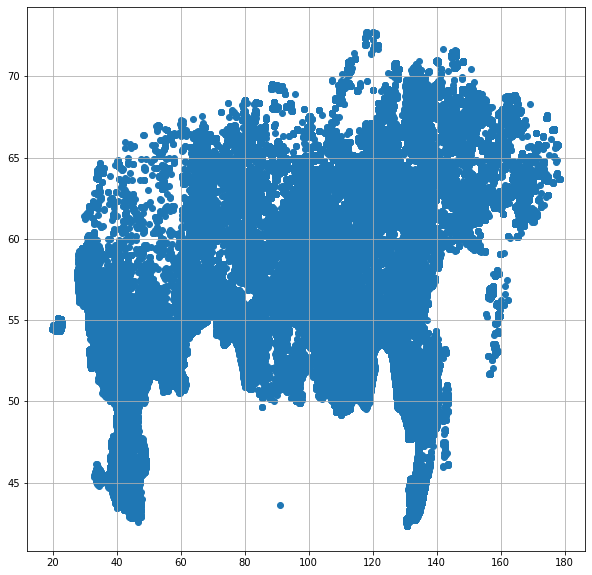

In [93]:
plt.figure(figsize=(10,10))
plt.scatter(x = data['lon'], y = data['lat'])
plt.grid(visible=True);

## Распределение по времени

In [94]:
dates_stats = data.groupby('dt').agg({'dt' : 'count'}).\
            rename(columns = {'dt' : 'fire_frequency'}).sort_values(by='dt')

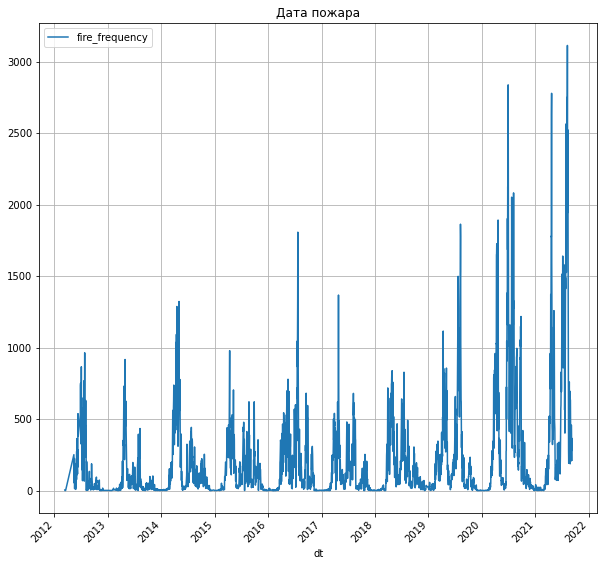

In [95]:
# видим, что пожары происходят по сути в летнее время + их кол-во растёт
dates_stats.plot(figsize = (10, 10), grid=True, rot=45, title='Дата пожара');

## Корреляционная матрица

In [96]:
# обоснование оставляемых элементов
data.corr()

,type_id,lon,lat,year,month,week
type_id,1.000000,0.104759,0.107591,0.045349,0.100077,0.106321
lon,0.104759,1.000000,0.225122,0.068143,0.132258,0.135222
lat,0.107591,0.225122,1.000000,0.297171,0.409203,0.410420
year,0.045349,0.068143,0.297171,1.000000,0.076359,0.064480
month,0.100077,0.132258,0.409203,0.076359,1.000000,0.986709
week,0.106321,0.135222,0.410420,0.064480,0.986709,1.000000


# Обучение модели

## Разделение данных на выборки

In [97]:
# random_seed = 99
features = data.drop(['type_id', 'dt'], axis=1)
target = data['type_id']

train_features, test_features, train_target, test_target = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=99)

In [98]:
train_features.shape, test_features.shape

((525477, 5), (131370, 5))

In [99]:
train_target.shape, test_target.shape

((525477,), (131370,))

## Выбор и тюнинг модели

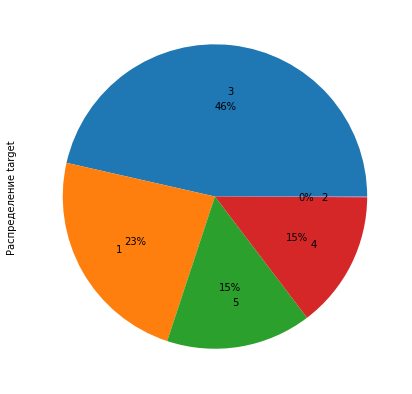

In [38]:
train_target.value_counts().plot(kind='pie',
                                  figsize = (7, 7),
                                  labeldistance=0.7,
                                  label = f'Распределение target',
                                  autopct='%1.0f%%');

In [39]:
# выбранная метрика качества - f1_score weighted (мультиклассовая задача + есть редкий класс)

# выбор модели - lgb + тюнинг hyperopt

In [40]:
param_space = {
    'learning_rate' : hp.uniform('learning_rate', 0.3, 0.5),
    'max_depth' : scope.int(hp.quniform('max_depth', 5, 100, 1)),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 1000, 3000, 1)),
    'num_leaves' : scope.int(hp.quniform('num_leaves', 10, 50, 1)),
    'min_child_samples' : scope.int(hp.quniform('min_child_samples', 10, 50, 1)),
    'min_split_gain' : hp.uniform('min_split_gain', 0, 0.3),
    'subsample' : hp.uniform('subsample', 0.5, 1),
    'subsample_freq' : scope.int(hp.quniform('subsample_freq', 0, 5, 1)),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha' : hp.choice('reg_alpha', [0, 1]),
    'reg_lambda' : hp.choice('reg_lambda', [0, 1]),
    'scale_pos_weight' : scope.int(hp.quniform('scale_pos_weight', 1, 10, 1)),
    'random_state' : hp.choice('random_state', ['22']),
    'objective' : hp.choice('objective', ['multiclass'])
}

In [41]:
def optimize(params, X, y, eval_features, eval_target):
    
    model = lgb.LGBMClassifier(**params)
    
    callbacks = [lgb.early_stopping(stopping_rounds = 100, verbose=0)]
    
    model.fit(X, y,
              eval_set=(eval_features, eval_target),
              callbacks = callbacks)
    
    predictions = model.predict(eval_features)
    
    score = metrics.f1_score(eval_target, predictions, average='weighted')
    
    return {'loss': -1.0 * score, 'status' : STATUS_OK}

In [42]:
optimization_function = partial(
    optimize,
    X = train_features,
    y = train_target,
    eval_features = test_features,
    eval_target = test_target
)

In [43]:
trials = Trials()

In [44]:
result = fmin(optimization_function, space=param_space, max_evals=10, trials=trials, verbose=10, algo=tpe.suggest)

100%|██████████████████████████████████████████████| 10/10 [18:14<00:00, 109.44s/trial, best loss: -0.8852579191226544]


In [104]:
new_params = space_eval(param_space, result)
model = lgb.LGBMClassifier(**new_params)

In [105]:
model.fit(train_features, train_target)

LGBMClassifier(colsample_bytree=0.8251460543710697,
               learning_rate=0.3378777615806956, max_depth=47,
               min_child_samples=32, min_split_gain=0.25132504290306434,
               n_estimators=1737, num_leaves=39, objective='multiclass',
               random_state='22', reg_alpha=0, reg_lambda=1, scale_pos_weight=8,
               subsample=0.5009281484738805, subsample_freq=3)

In [106]:
predictions = model.predict(test_features)
score = metrics.f1_score(test_target, predictions, average='weighted')
score

0.8849333122657119

## confusion matrix результатов

сonfusion_matrix для класса : Неконтролируемый пал


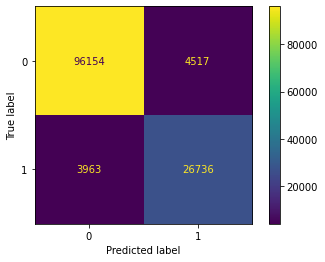

сonfusion_matrix для класса : Торфяной пожар


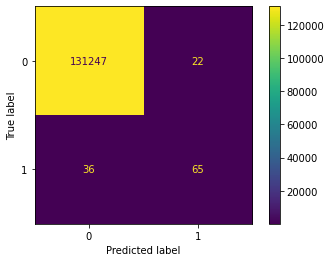

сonfusion_matrix для класса : Лесной пожар


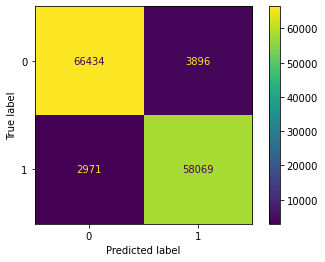

сonfusion_matrix для класса : Природный пожар


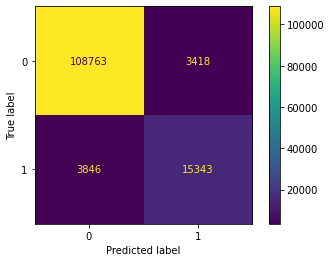

сonfusion_matrix для класса : Контролируемый пал


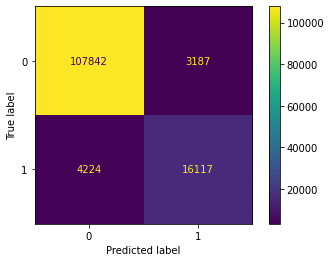

In [139]:
confusion_matrixes = multilabel_confusion_matrix(test_target, predictions)

label = 1
for confusion_matrix in confusion_matrixes:
    print(f'сonfusion_matrix для класса : {types_dict[label]}')
    label += 1
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot()
    plt.show()

## Сохранение предсказаний на тестовой выборке

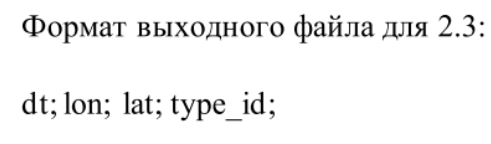

In [120]:
predicted_data = data.loc[test_features.index, ['dt', 'lon', 'lat']]
predicted_data['type_id'] = predictions
predicted_data.to_csv(r'C:\Users\Lenovo\Desktop\rt\КЧ2022\classified_1.csv')

In [121]:
predicted_data['predicted'] = 1
true_data = data.loc[test_features.index, ['dt', 'lon', 'lat', 'type_id']]
true_data['predicted'] = 0

In [122]:
agg_data = pd.concat([predicted_data, true_data])

# Визуализация результатов

## Сравнение классификации модели с правильными ответами

In [123]:
agg_data['type_id'] = agg_data['type_id'].map(types_dict)

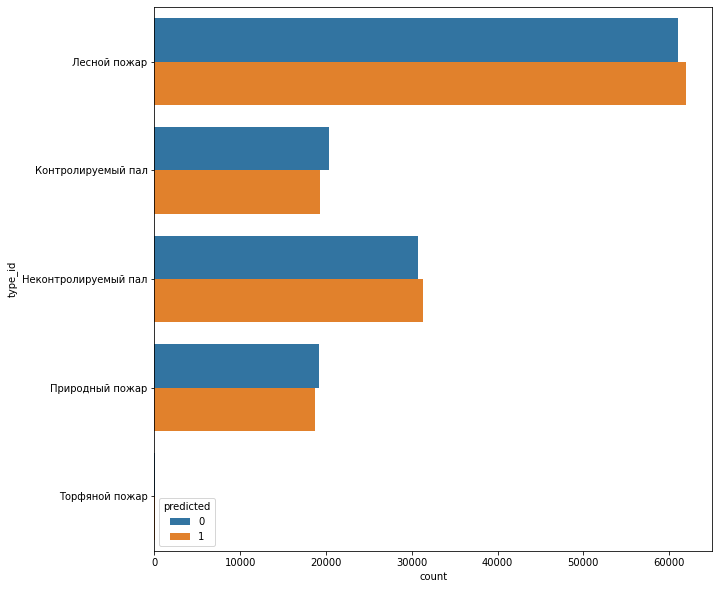

In [140]:
# посмотрим как распределён target в финальном датасете
fig = plt.figure(figsize=(10,10))

sns.countplot(y = agg_data['type_id'],
              hue=agg_data['predicted'])

plt.show()

<Figure size 720x720 with 0 Axes>

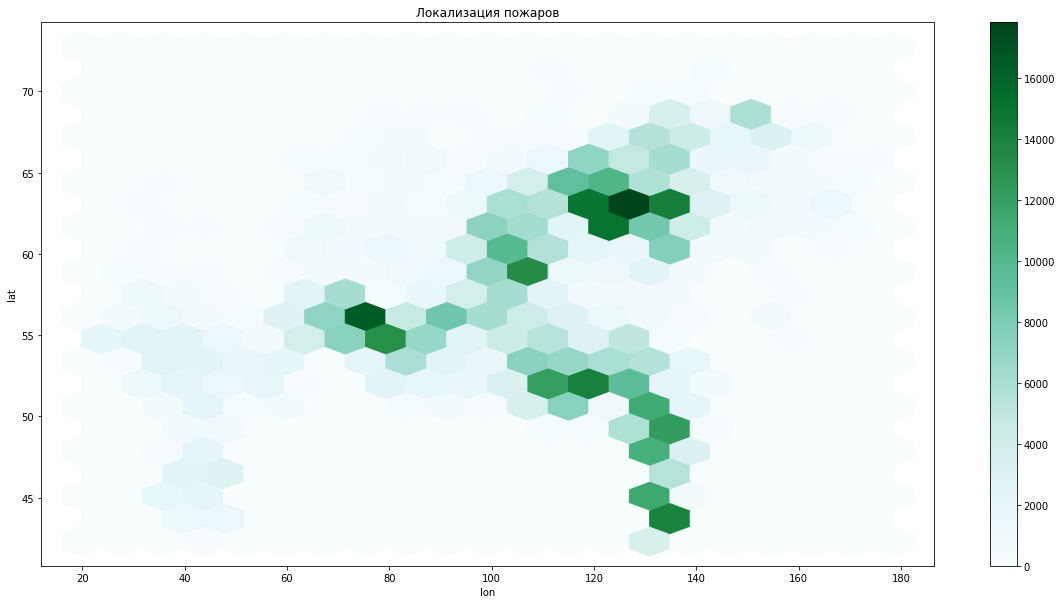

In [141]:
fig = plt.figure(figsize=(10,10))
data.plot(x='lon', y='lat', kind='hexbin', gridsize=20, sharex=False, figsize=(20, 10))
plt.title('Локализация пожаров')
plt.show();